In [1]:
!bash /home/azureuser/cloudfiles/code/blobfuse/blobfuse_raadsinformatie.sh

In [40]:
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 83.0 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.0/311.0 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 92.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 88.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 8.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Set-up paths - either AZURE or LOCAL 

In [ ]:
import sys
sys.path.append("..")

# Select where to run notebook: "azure" or "local"
my_run = "azure"

import my_secrets as sc
import settings as st

if my_run == "azure":
    import config_azure as cf
elif my_run == "local":
    import config as cf

### Load data

In [11]:
import sys
sys.path.append('../scripts/') 

import pandas as pd
from load_data import load_txt_files

txtfile_paths = pd.read_csv("../data/txtfile_paths.csv")
display(txtfile_paths)

all_txt_df = load_txt_files(txtfile_paths, ['complete'])

,label,path,id,set
0,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,0,train
1,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,1,train
2,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,2,train
3,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,3,train
4,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,4,test
...,...,...,...,...
33123,Factsheets,/home/azureuser/cloudfiles/code/blobfuse/raads...,33123,train
33124,Factsheets,/home/azureuser/cloudfiles/code/blobfuse/raads...,33124,val
33125,Factsheets,/home/azureuser/cloudfiles/code/blobfuse/raads...,33125,train
33126,Factsheets,/home/azureuser/cloudfiles/code/blobfuse/raads...,33126,train


In [16]:
display(all_txt_df)
df = all_txt_df.copy()

,label,path,id,set,text
0,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,0,train,Gemeente Amsterdam\n% Gemeenteraad R\n% Gemeen...
1,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,1,train,Gemeente Amsterdam\n\n% Gemeenteraad R\n\n% Ge...
2,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,2,train,Gemeente Amsterdam\n\n% Gemeenteraad R\n\n% Ge...
3,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,3,train,Gemeente Amsterdam\n\n% Gemeenteraad R\n\n% Ge...
4,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,4,test,x Gemeente Amsterdam R\nGemeenteraad\n\n% Geme...
...,...,...,...,...,...
33123,Factsheets,/home/azureuser/cloudfiles/code/blobfuse/raads...,33123,train,"In Amsterdam is, net als in andere delen van h..."
33124,Factsheets,/home/azureuser/cloudfiles/code/blobfuse/raads...,33124,val,| September 2021 C 1 / )\nr 1E | rs | a 4 in\n...
33125,Factsheets,/home/azureuser/cloudfiles/code/blobfuse/raads...,33125,train,WPI KWARTAAL FACTSHEET DECEMBER 2022\nKERNCIJF...
33126,Factsheets,/home/azureuser/cloudfiles/code/blobfuse/raads...,33126,train,"WPI VOORTGANGSRAPPORTAGE\nKERNCIJFERS WERK, PA..."


## EDA

##### Missing data
Remove rows where the text was not extracted correctly

In [17]:
import numpy as np

missing_text = df[df['text'].str.len() < 5]
print(f"There are {len(missing_text)} documents that have less than 5 characters")

print(f"Removing the documents that could not be extracted or have less than 5 characters, leaves us with {len(df)-len(missing_text)} (out of {len(df)})")
df = df[df['text'].str.len() > 5]


There are 11 documents that have less than 5 characters
Removing the documents that could not be extracted or have less than 5 characters, leaves us with 33117 (out of 33128)


### Tokenization

In [25]:
import nltk
from nltk.tokenize import word_tokenize
# nltk.download('punkt')

df['tokens'] = df['text'].apply(word_tokenize)

def calculate_length(token_list):
    return len(token_list)

df['token_length'] = df['tokens'].apply(calculate_length)
display(df)


[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##### Token length
Below are the tables shown for the complete dataset and the classes.

We can see that the token lengths within the classes and between the classes are varying. 
Note: the minimum values are very small. This is likely a result of mistakes made during converting PDF to OCR. Further expection is needed to remove bad files.

In [62]:
display(df['token_length'].describe())
class_describe = df.groupby('label')['token_length'].describe()
display(class_describe)

count     33117.000000
mean       2691.847933
std       13409.818780
min           3.000000
25%         291.000000
50%         533.000000
75%        1225.000000
max      275597.000000
Name: token_length, dtype: float64

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Actualiteit,996.0,696.773092,3462.293848,72.0,236.00,344.5,592.0,103700.0
Adviesaanvraag,2442.0,1644.871417,2993.302964,57.0,557.00,955.0,1672.0,77769.0
Agenda,3537.0,1048.904156,4244.783305,20.0,325.00,616.0,939.0,139648.0
Amendement,1969.0,2658.493652,7044.470410,30.0,236.00,359.0,1184.0,62304.0
Begroting,1967.0,13160.190646,46780.793626,40.0,248.00,385.0,2324.0,247184.0
Besluit,775.0,986.649032,1749.006500,70.0,168.50,439.0,1216.0,26523.0
Brief,1995.0,1764.259649,1728.612069,3.0,734.00,1269.0,2291.5,32957.0
Factsheets,234.0,6008.987179,14742.837685,112.0,1154.00,2753.5,5462.0,171297.0
Motie,8336.0,521.707893,1129.571368,105.0,234.00,292.5,402.0,36091.0


Inspect each class for the minimum lengths, are the texts reasonable. Or mistake with converting PDF to OCR.

In [60]:
# ### Actualiteit
# subdf = df.loc[(df['token_length']<80) & (df['token_length']>0) & (df['label']=='Actualiteit')]
# for index, row in subdf.iterrows():
#     print(row['text'])
#     print('\n\n\n')

#### Top words for each class

In [1]:
from collections import Counter
def get_top_words(tokens):
    word_count = Counter(tokens)
    return word_count.most_common(15)

top_df = df.copy()
top_words_by_class = top_df.groupby('label')['tokens'].sum().apply(get_top_words)
display(top_words_by_class)


NameError: name 'df' is not defined

## Code to extract text from PDF

In [3]:
import os

print(f"There are {len(os.listdir(cf.folder_path_annotated))} subfolders in the rootfolder")

total_count = 0

for folder in os.listdir(cf.folder_path_annotated):
    if folder != '.keep':
        total_count += len(os.listdir(cf.folder_path_annotated+folder))
print(f"There are in total {total_count} files in the rootfolder")

There are 28 subfolders in the rootfolder
There are in total 163 files in the rootfolder


In [4]:
import os
import random
import pandas as pd
from PyPDF2 import PdfReader
from collections import defaultdict

# Function to extract text from PDF and get page count
def extract_text_and_count_from_pdf(pdf_path):
    try: 
        text = ""
        page_count = 0
        with open(pdf_path, 'rb') as f:
            reader = PdfReader(f)
            page_count = len(reader.pages)
            for page in reader.pages:
                text += page.extract_text()
        return text, page_count
    
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
        return '', 0


def create_df_from_pdfs(root_folder):
    data = []
    
    # each folder in the rootfolder contains PDFs for one class
    for doc_class in os.listdir(root_folder):

        # there was a weird folder
        if doc_class != '.keep':

            # for every PDF in a folder, save the class, extract the text and count the pages
            for pdf in  os.listdir(root_folder+doc_class):

                # make sure only pdf files are extracted
                if pdf.endswith('.pdf') and len(pdf)>0:
                    pdf_path = root_folder+doc_class+'/'+pdf
                    pdf_text, pdf_page_count = extract_text_and_count_from_pdf(pdf_path)

                    data.append({'filename':pdf, 'text':pdf_text, 'class':doc_class, 'number_pages':pdf_page_count})
    df = pd.DataFrame(data)
    return df
df = create_df_from_pdfs(cf.folder_path_annotated)
display(df)


ImportError: C extension: None not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

### Display DF

In [4]:
import pandas as pd
df = pd.read_csv(cf.file_path_annotated_csv)
display(df.head())

,filename,text,class,number_pages
0,A - 06 Algemene Zaken (1) 03_Proces_Nieuwe MRA...,\n \n \nAanleiding \nIn dit memo is op hoof...,Memo,9
1,A - 03 Democratisering (inclusief Bestuurlijk ...,1 Delegatie en mandaat van raadsbevoegdheden ...,Advies,26
2,A - 04 Ruimtelijke Ordening (23) 4a_ Advies DB...,Pagina 1 van 3Adviesaanvraag college aan dage...,Advies,3
3,A - 04 Ruimtelijke Ordening (23) 4b_ Advies co...,Pagina 1 van 4 \n Adviesaanvraag college a...,Advies,4
4,A - 04 Ruimtelijke Ordening (23) 4c_ Advies DB...,Pagina 1 van 3Adviesaanvraag college aan dage...,Advies,3


### Missing data
- empty text 
- zero pages -> those are the files that gave an error when trying to extract text from them.

In [5]:
import numpy as np

missing = df.loc[df['number_pages'] == 0]
print(f"There are {len(missing)} PDF files that gave an error while extracting the text.")

missing_text = df[df['text'].str.len() < 5]
print(f"There are {len(missing_text)} documents that have less than 5 characters")

print(f"Removing the documents that could not be extracted or have less than 5 characters, leaves us with {len(df) - len(missing)-len(missing_text)} (out of {len(df)})")
df = df.loc[df['number_pages'] != 0]
df = df[df['text'].str.len() > 5]


There are 2 PDF files that gave an error while extracting the text.
There are 0 documents that have less than 5 characters
Removing the documents that could not be extracted or have less than 5 characters, leaves us with 161 (out of 163)


### Basic Statistics

- Counts, class distribution
- Length distribution
- Number of unique words

**CREATE DATAFRAME FOR PAGE DISTRIBUTION**

The cell below shows code for the amount of pages distribution for the whole dataset and for each class. 

,class,Min_Pages,Max_Pages,Mean_Pages,Mode_Pages,Document_Count
0,WholeDataset,1,416,14.212500,2,160
1,Actualiteit,1,2,1.333333,1,3
2,Advies,2,26,6.375000,3,8
3,Adviesaanvraag,2,3,2.666667,3,3
4,Agenda,1,8,3.833333,3,6
5,Agendaplanning,2,3,2.500000,2,2
6,Amendement,2,2,2.000000,2,3
7,Artikel,2,139,30.600000,2,5
8,Begroting,51,51,51.000000,51,1
9,Besluit,1,14,4.384615,3,13


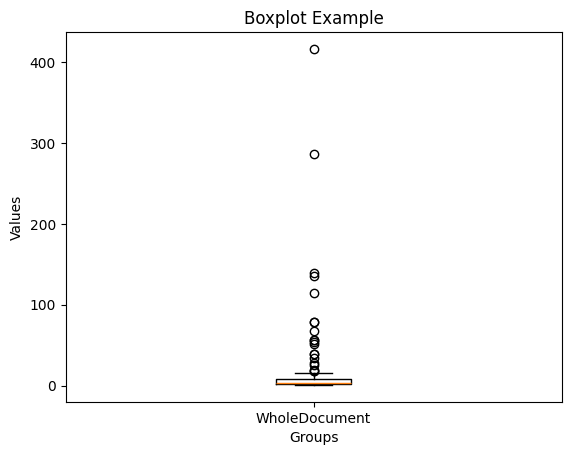

In [23]:
from collections import Counter
from statistics import mean, mode

"""CREATE DATAFRAME FOR PAGE DISTRIBUTION"""

# For each class
class_stats = df.groupby('class')['number_pages'].agg(['min', 'max', 'mean', lambda x: x.mode()[0], 'count'])
class_stats.columns = ['Min_Pages', 'Max_Pages', 'Mean_Pages', 'Mode_Pages', 'Document_Count']
class_stats.reset_index(inplace=True)

# For the whole dataste
new_row = {'class':'WholeDataset', 'Min_Pages':min(class_stats['Min_Pages']), 'Max_Pages': max(class_stats['Max_Pages']), 
           "Mean_Pages": mean(df['number_pages']), 'Mode_Pages': mode(df['number_pages']), 'Document_Count':len(df)}
df_stats = pd.DataFrame(new_row, index=[0])
class_stats = pd.concat([df_stats, class_stats])
class_stats.reset_index(inplace=True)

# Combine dfs
stats = class_stats.drop(columns=['index'])
display(stats)

"""CREATE BOXPLOT FOR PAGES LENGTHS"""
import matplotlib.pyplot as plt

plt.boxplot(df['number_pages'], labels=['WholeDocument'])

# Adding title and labels
plt.title('Boxplot Example')
plt.xlabel('Groups')
plt.ylabel('Values')

# Showing plot
plt.show()


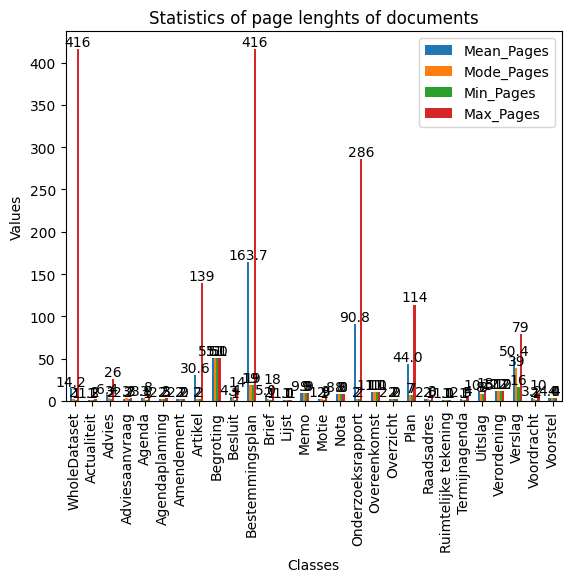

<Figure size 2500x600 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt 

ax = stats.plot(x="class", y=["Mean_Pages", "Mode_Pages", 'Min_Pages', "Max_Pages"], kind="bar") 
# ax = stats.plot(x="class", y=["Mean_Pages"], kind="bar") 

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 1)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

# Adding labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Values')
ax.set_title('Statistics of page lenghts of documents')

plt.figure(figsize=(25,6))
plt.show()


### Similarity WITHIN a class

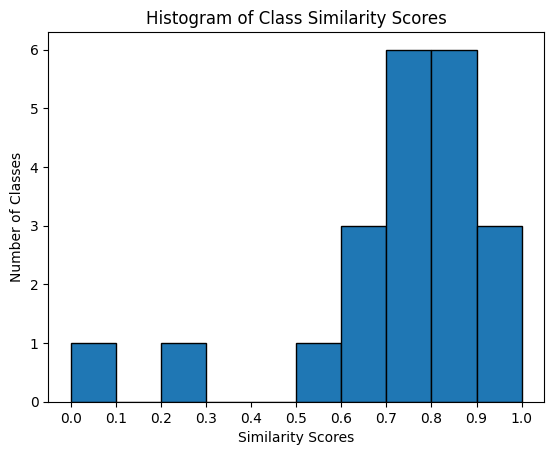

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt

# Initialize an empty dictionary to store similarity scores for each class
class_similarity = {'WholeDataset':np.nan}

# Group the DataFrame by class
grouped = df.groupby('class')

# Iterate over each class
for class_name, group in grouped:
    # Tokenize the text for documents in the class
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(group['text'])
    
    # Compute pairwise cosine similarity between documents
    similarity_matrix = cosine_similarity(X)
    
    # Compute the average similarity score for the class
    similarity_scores = []
    for i, j in combinations(range(len(group)), 2):
        similarity_scores.append(similarity_matrix[i, j])

    # cant calculate similarity for classes with 1 document
    if len(similarity_scores) > 0:
        avg_similarity = sum(similarity_scores) / len(similarity_scores)
        class_similarity[class_name] = avg_similarity
    else:
        class_similarity[class_name] = np.nan

stats['class_similarity'] = class_similarity.values()

bins = np.arange(0, 1.1, 0.1)

# Create the histogram
plt.hist(stats.iloc[1:]['class_similarity'], bins=bins, edgecolor='black')

# Add labels and title
plt.xlabel('Similarity Scores')
plt.ylabel('Number of Classes')
plt.title('Histogram of Class Similarity Scores')
plt.xticks(np.arange(0, 1.1, 0.1)) 

# Show plot
plt.show()





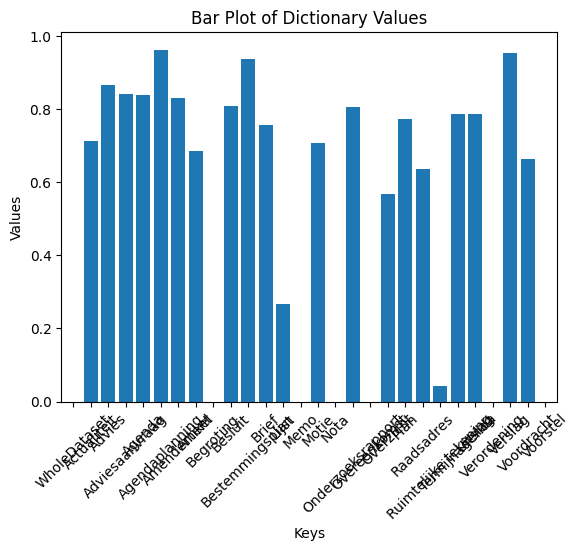

In [43]:

keys = list(class_similarity.keys())
values = list(class_similarity.values())

# Plot bar plot
plt.bar(keys, values)
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Bar Plot of Dictionary Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [35]:
print(class_similarity)

{'Actualiteit': 0.7132208687200694, 'Advies': 0.8661525301300504, 'Adviesaanvraag': 0.8420850736304262, 'Agenda': 0.8379293893462135, 'Agendaplanning': 0.962930810857555, 'Amendement': 0.8312726654222452, 'Artikel': 0.6860096369733448, 'Besluit': 0.8080796710685713, 'Bestemmingsplan': 0.937587783296364, 'Brief': 0.7561284777071262, 'Lijst': 0.26777240800208874, 'Motie': 0.7067409213771989, 'Onderzoeksrapport': 0.8062121288924066, 'Overzicht': 0.569232739422041, 'Plan': 0.7740532952087466, 'Raadsadres': 0.6369468315392182, 'Ruimtelijke tekening': 0.04268017050505208, 'Termijnagenda': 0.7867804554555011, 'Uitslag': 0.7876611756229989, 'Verslag': 0.952313286798887, 'Voordracht': 0.6648709996211685}


In [27]:
%pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 99.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.5/38.5 MB 34.0 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.
